In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

d2l.init_Seed()
device = d2l.get_device()

GPU ready!


In [2]:
config = {
    "n_train": 100,
    "n_test": 100,
    "max_degree": 20,
    "train_degree": 4,
    "batch_size": 10,
    "n_epochs": 40,
#     "optimizer": "SGD",
    "optimizer": "Adam",
    # "optimizer": "Adagrad",
    # "optimizer": "Adadelta",
    "optim_hparas": {
        'lr': 0.2,         # for SGD and Adam
#         'momentum': 0.9,
#         'nesterov':True
    },
    'lr_scheduler': 'StepLR',
    'lr_sched_hparas':{
        'step_size': 100,
        'gamma': 0.97
    }
}

In [3]:
def generate_feature(x, max_degree, scaler):
    features = x.pow(torch.arange(max_degree))
#     for i in range(max_degree):
#         features[:, i] /= math.gamma(i + 1)
    if not hasattr(scaler, 'scale_'):
        scaler.fit(features.numpy())
    features = torch.tensor(scaler.transform(features.numpy()))
    return features

def poly(x, w, scaler):
    max_degree = len(true_w)
    features = generate_feature(x, max_degree, scaler)
    # print(features.shape, w.shape)

    return features, features @ w

def initial(true_w, scaler, n_train=100, n_test=100):
    X = torch.randn((n_train + n_test, 1))
    X, y = poly(X, true_w, scaler)
    y += torch.normal(0, 0.1, y.shape)
    return X, y

In [4]:
scaler = StandardScaler()
true_w = torch.zeros(config['max_degree'])
true_w[0:4] = torch.tensor([5, 1.2, -3.4, 5.6])
X, y = initial(true_w, scaler, n_train=config['n_train'], n_test=config['n_test'])
tr_set = d2l.prep_dataloader(X[:config['n_train'], :config['train_degree']], y[:config['n_train']], 'train', config['batch_size'])
te_set = d2l.prep_dataloader(X[config['n_train']:, :config['train_degree']], y[config['n_train']:], 'test', config['batch_size'])

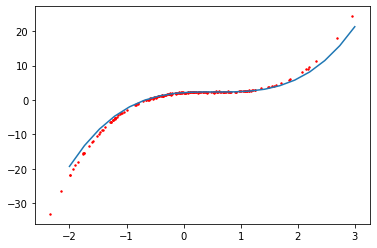

In [5]:
fig, ax = plt.subplots()
ax.scatter(X[:, 1].numpy(), y.numpy(), c='red', s=2)

x = torch.linspace(-2, 3, 20).reshape(-1, 1)
ax.plot(x.numpy(), poly(x, true_w, scaler)[-1].numpy())

In [6]:
gg = torch.tensor([[1., 2.], [3., 4.]])
(gg - gg.mean()) / gg.std(unbiased=False)

tensor([[-1.3416, -0.4472],
        [ 0.4472,  1.3416]])

In [7]:
class MLP(nn.Module):
    def __init__(self, input_degree):
        super().__init__()
        
        self.net = nn.Sequential(nn.Linear(input_degree, 1, bias=False))
        
        def init_weights(m):
            if type(m) == nn.Linear:
                nn.init.normal_(m.weight, std=0.01)

        # self.net[0].weight.data.fill_(-1.5)
        # self.net[0].weight.data = torch.tensor([[-1., -1.]])
        self.net.apply(init_weights)


    def forward(self, X):
        return self.net(X).squeeze(1)


0.009490512311458588
tensor([[ 0.0066,  1.2238, -3.4047,  5.5744]], grad_fn=<CopyBackwards>)


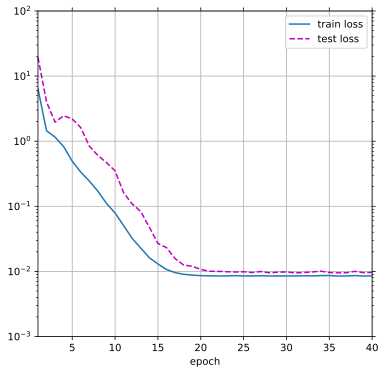

In [8]:
loss = nn.MSELoss(reduction='mean')
model = MLP(input_degree=config['train_degree']).to(device)
optimizer = getattr(torch.optim, config["optimizer"])(
    model.parameters(), **config["optim_hparas"]
)

lr_scheduler = getattr(torch.optim.lr_scheduler, config["lr_scheduler"])(optimizer, **config["lr_sched_hparas"])

min_loss = d2l.train_reg(model, tr_set, te_set, loss, optimizer, lr_scheduler, device, config['n_epochs'])
print(min_loss)
print(model.net[0].weight.cpu())